### 1. 正则化线性回归

这一部分，我们需要先对一个水库的流出水量进行正则化线性回归。然后将会探讨方差-偏差的问题

#### 1.1 数据可视化

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = sio.loadmat('./ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel, [data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

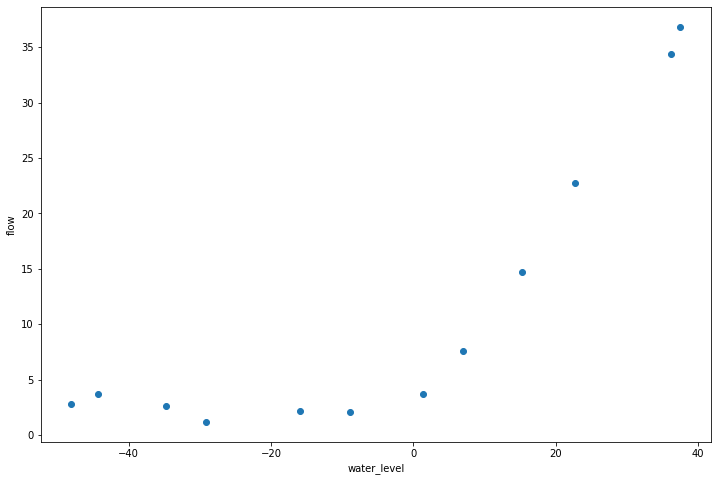

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
plt.show()

#### 1.2 正则化线性回归代价函数

正则化线性回归代价函数公式如下：

$$
J(\theta)=\frac{1}{2m}(\sum^{m}_{i=1}(h_{\theta}(x^{(i)})-y^{(i)})^2)+\frac{\lambda}{2m}(\sum^{n}_{j=1}\theta^2_j)
$$

其中$\theta$是正则化参数，它控制了正则化的速度。正则化项在原来的代价J上加了一个惩罚项。随着参数$\theta_j$的变大，惩罚项也会增大。另外不需要正则化$\theta_0$

下面完成计算正则化线性回归代价函数的代码。theta初始值为\[1, 1]，输出应该为303.993

In [4]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [5]:
def cost(theta, X, y):
    m = X.shape[0]
    inner = X @ theta - y
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    return cost

In [6]:
def costReg(theta, X, y, reg=1):
    m = X.shape[0]
    regularized_term = (reg / (2 * m)) * np.power(theta[1:], 2).sum()
    return cost(theta, X, y) + regularized_term

In [7]:
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1)

303.9931922202643

#### 1.3 正则化线性回归的梯度

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum^{m}_{i=1}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j ,\space\space\space for \space\space j = 0
$$
$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum^{m}_{i=1}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j + \frac{\lambda}{m} \theta_j, \space\space\space for \space\space j \geq 0
$$

设定$\theta$初始值为\[1, 1]，输出应该为\[-15.30, 598.250]

In [36]:
def gredient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)
    return inner / m

In [37]:
def gradientReg(theta, X, y, reg):
    m = X.shape[0]

    regularized_term = theta.copy()
    regularized_term[0] = 0

    regularized_term = (reg / m) * regularized_term

    return gredient(theta, X, y) + regularized_term

In [38]:
gradientReg(theta, X, y, 1)

array([-15.30301567, 598.25074417])

#### 1.4 拟合线性回归

调用工具库找到$\theta$最优解，在这个部分，我们令$\lambda$=0。因为我们现在训练的是2维的$\theta$，所以正则化不会对这种低维的$\theta$有很大的帮助。

完成之后，将数据和拟合曲线可视化。

In [40]:
theta = np.ones(X.shape[1])
final_theta = opt.minimize(fun=costReg, x0=theta, args=(X, y, 0), method='TNC', jac=gradientReg, options={'disp': True}).x
final_theta

array([13.08790362,  0.36777923])

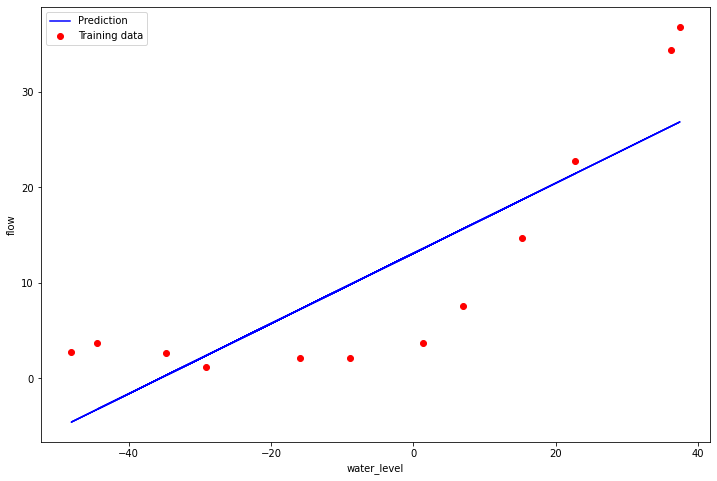

In [41]:
b = final_theta[0]
m = final_theta[1]

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(X[:, 1], y, c='r', label='Training data')
plt.plot(X[:, 1], X[:, 1] * m + b, c='b', label='Prediction')
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

### 2 方差和偏差

机器学习中的一个重要概念是偏差-方差权衡。偏差较大的模型会欠拟合，而方差较大的模型会过拟合。这部分会让你画出学习曲线来判断方差和偏差的问题。

#### 2.1 学习曲线

1. 使用训练集的子集来拟合应模型
2. 在计算训练代价和验证集代价时，没有用正则化
3. 记住使用相同的训练子集来计算训练代价

代价公式为：
$$
J_{train}(\theta) = \frac{1}{m}[\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2]
$$

In [42]:
def linear_regression(X, y, l=1):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun=costReg, x0=theta, args=(X, y, l), method='TNC', jac=gradientReg, options={'disp': True})
    return res

In [43]:
training_cost, cv_cost = [], []

In [44]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression(X[:i, :], y[:i], 0)

    tc = costReg(res.x, X[:i, :], y[:i], 0)
    cv = costReg(res.x, Xval, yval, 0)

    training_cost.append(tc)
    cv_cost.append(cv)

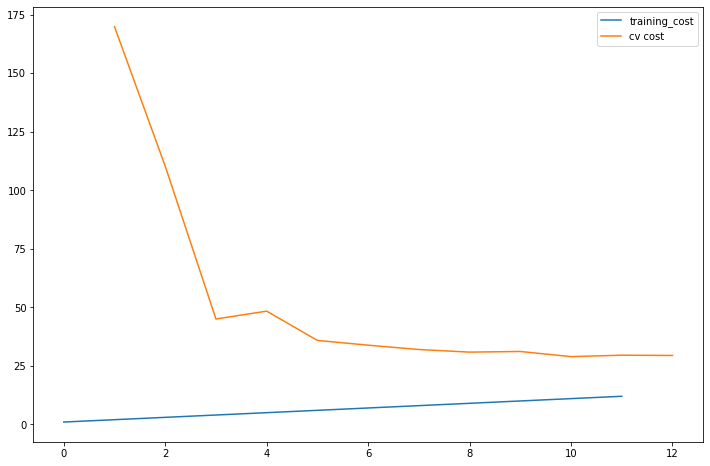

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(np.arange(1, m+1), label='training_cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend()
plt.show()

### 3 多项式回归

线性回归对于现有数据来说太简单了，会欠拟合，我们需要多添加一些特征。

写一个函数，输入原始X，和幂的次数p，返回X的1到p次幂

In [46]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power+1)}
    df = pd.DataFrame(data)

    return df.values if as_ndarray else df

In [47]:
data = sio.loadmat('./ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel, [data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

In [48]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


#### 3.1 多项式回归

1. 使用之前的代价函数和梯度函数
2. 扩展特征到8阶特征
3. 使用归一化来处理$x^n$
4. $\lambda=0$

In [49]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [52]:
def prepare_poly_data(*args, power):
    def prepare(x):
        df = poly_features(x, power=power)
        ndarr = normalize_feature(df).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [53]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])